# Give Me Some Credit

In [223]:
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pointbiserialr

from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from typing import List
from IPython.display import display

from src.constants import TRAIN_DATA_PATH, TEST_DATA_PATH, LABEL_COL, FEATURES_COL_LIST, RANDOM_SEED, VAL_SIZE

np.random.seed(RANDOM_SEED)

In [224]:
def get_biserial_correlation_stats(
    train_df: pd.DataFrame,
    label_col: str,
    feature_col_list: List[str],
    should_plot: bool = True,
)->pd.DataFrame:

    biserial_corr_dict = {
        "feature" : [],
        "biserial_correlation" : [],
    }

    corr_df = train_df.copy(deep=True).dropna()

    for feat in feature_col_list:
        corr = pointbiserialr(corr_df[label_col], corr_df[feat])
        biserial_corr_dict["feature"].append(feat)
        biserial_corr_dict["biserial_correlation"].append(corr.correlation)

    biserial_corr_df = pd.DataFrame(biserial_corr_dict)

    if should_plot:
        plt.figure()
        plt.title(f"Biserial Correlation of Features vs {LABEL_COL}", fontsize=14)
        sns.barplot(y="feature", x="biserial_correlation", data=biserial_corr_df.sort_values(by=["biserial_correlation"]), color="tab:red")
        plt.show()

    return biserial_corr_df

def get_correlation_df(
    train_df, 
    label_col: str,
    feature_col_list: List[str],
    should_plot: bool = True,
)->pd.DataFrame:
    
    corr_df = train_df[[label_col] + feature_col_list].corr()

    if should_plot:
        plt.figure()
        plt.title("Correlation Heatmap", fontsize=14)
        sns.heatmap(corr_df)
        plt.show()

    return corr_df 

def get_base_rf_auc_feature_importance(
    train_df: pd.DataFrame,
    label_col: str,
    feature_col_list: List[str],
    random_seed: int = RANDOM_SEED,
    val_size: float = VAL_SIZE,
):
    fit_df = train_df.copy(deep=True).dropna()

    X = fit_df[feature_col_list]
    y = fit_df[label_col]

    X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=random_seed, test_size=val_size)

    prelim_clf = RandomForestClassifier(max_depth=10)
    prelim_clf.fit(
        X=X_train,
        y=y_train,
    )

    prelim_train_pred = prelim_clf.predict_proba(X_train)
    prelim_val_pred = prelim_clf.predict_proba(X_val)
    prelim_train_roc_auc = roc_auc_score(y_true=y_train, y_score=prelim_train_pred[:, 1])
    prelim_val_roc_auc = roc_auc_score(y_true=y_val, y_score=prelim_val_pred[:, 1])

    ft_importance_df = pd.DataFrame({
        "feature" : feature_col_list,
        "rf_feature_importance" : prelim_clf.feature_importances_,
    }).sort_values(by="rf_feature_importance", ascending=False)

    return prelim_clf, prelim_train_roc_auc, prelim_val_roc_auc, ft_importance_df


def get_cap_dict(
    train_df: pd.DataFrame,
    ratio_cols: List[str],
    non_ratio_cols: List[str],
    percentile_for_cap: float = 99.0
)->dict:
    cap_dict = {}

    for col in ratio_cols:
        cap_dict[col] = 1.0
    
    for col in non_ratio_cols:
        cap = np.nanpercentile(train_df[col], percentile_for_cap)
        cap_dict[col] = cap
    
    return cap_dict


def get_capped_df(
    df: pd.DataFrame,
    cap_dict: dict,
)->pd.DataFrame:
    capped_df = df.copy(deep=True)

    for col, cap in cap_dict.items():
        capped_df[col] = np.where(capped_df[col] > cap, cap, capped_df[col])
    
    return capped_df

In [225]:
train_df = pd.read_csv(TRAIN_DATA_PATH).rename(columns={
    "Unnamed: 0" : "id"
})

train_df.index = train_df.index.astype(np.int32)

test_df = pd.read_csv(TEST_DATA_PATH).rename(columns={
    "Unnamed: 0" : "id"
})

test_df.index = test_df.index.astype(np.int32)

### Ratio of Positive Class in the Training Set

Inspection of the label column reveals that there are only `6.68%` of the positive class, indicating a class imbalance in the dataset. We might need to deal with this during the model fitting then.

In [226]:
print(f"There are {train_df[LABEL_COL].mean() * 100:.2f} % positive classes in the training data")

There are 6.68 % positive classes in the training data


### Data types of the target and variables

From inspecting the data types, we can see that all the features are numerical (no `object` dtypes). Most likely, there will not be any categorical encoding needed.

In [227]:
display(train_df.dtypes)

id                                        int64
SeriousDlqin2yrs                          int64
RevolvingUtilizationOfUnsecuredLines    float64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
MonthlyIncome                           float64
NumberOfOpenCreditLinesAndLoans           int64
NumberOfTimes90DaysLate                   int64
NumberRealEstateLoansOrLines              int64
NumberOfTime60-89DaysPastDueNotWorse      int64
NumberOfDependents                      float64
dtype: object

### Inspecting NULL values

Next, we inspect the `NULL` values that are present in the training data.

We can see that only `MonthlyIncome` and `NumberOfDependents` have `NULL` values.

We will need to devise imputation strategies for these two columns.

In [228]:
display(train_df.isnull().sum())

id                                          0
SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

### Preliminary Summary Statistics

Next, we inspect the summary statistics of each of the feature columns. Notable insights:

- `DebtRatio`: given the name, the feature should have value ranging from 0 to 1. Yet, the max is `61106.5`. We will cap this feature at `1.0`.
- `MonthlyIncome`: the difference between `p75` and `max` value is very large. We might need to inspect the `p98-99` and deal with the outliers accordingly.

For the other variables, we will inspect whether it improves preliminary performance of the model fitting if the features are capped at a certain percentile value. Since there are no negative outliers, we can cap only the high outliers.

In [229]:
display(train_df.dropna()[FEATURES_COL_LIST].describe().T)

,count,mean,std,min,25%,50%,75%,max
RevolvingUtilizationOfUnsecuredLines,120269.0,5.899873,257.040685,0.0,0.035084,0.177282,0.579428,50708.0
age,120269.0,51.289792,14.426684,0.0,40.000000,51.000000,61.000000,103.0
NumberOfTime30-59DaysPastDueNotWorse,120269.0,0.381769,3.499234,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,120269.0,26.598777,424.446457,0.0,0.143388,0.296023,0.482559,61106.5
MonthlyIncome,120269.0,6670.221237,14384.674215,0.0,3400.000000,5400.000000,8249.000000,3008750.0
NumberOfOpenCreditLinesAndLoans,120269.0,8.758475,5.172835,0.0,5.000000,8.000000,11.000000,58.0
NumberOfTimes90DaysLate,120269.0,0.211925,3.465276,0.0,0.000000,0.000000,0.000000,98.0
NumberRealEstateLoansOrLines,120269.0,1.054519,1.149273,0.0,0.000000,1.000000,2.000000,54.0
NumberOfTime60-89DaysPastDueNotWorse,120269.0,0.187829,3.447901,0.0,0.000000,0.000000,0.000000,98.0
NumberOfDependents,120269.0,0.851832,1.148391,0.0,0.000000,0.000000,2.000000,20.0


### Preliminary model fitting asssessment

Before we decide to impute and cap, hence "hand-engineering" the features, we should get a baseline prediction performance (`roc_auc`) using `RandomForestClassifier` out-of-the box, just to get a sense of the performance that we should expect from the original dataset. This is to check the preliminary baseline that we should expect before we interfere with the features too much, in case we are eliminating the important variance throughout the process.

In order to get a sense of a baseline unseen performance, we will split the training set into train and validation set. As a preliminary assessment, we will inspect the:

- `roc_auc` on the train set
- `roc_auc` on the val set
- `feature_importance` of each feature

In [230]:
prelim_clf, prelim_train_roc_auc, prelim_val_roc_auc, ft_importance_df = get_base_rf_auc_feature_importance(
    train_df=train_df,
    label_col=LABEL_COL,
    feature_col_list=FEATURES_COL_LIST,
)

In [231]:
print(f"Preliminary training ROC-AUC score: {prelim_train_roc_auc:.6f}")
print(f"Preliminary validation ROC-AUC score: {prelim_val_roc_auc:.6f}")
display(ft_importance_df)

Preliminary training ROC-AUC score: 0.884800
Preliminary validation ROC-AUC score: 0.858181


,feature,rf_feature_importance
6,NumberOfTimes90DaysLate,0.255980
0,RevolvingUtilizationOfUnsecuredLines,0.195674
8,NumberOfTime60-89DaysPastDueNotWorse,0.148485
2,NumberOfTime30-59DaysPastDueNotWorse,0.118372
3,DebtRatio,0.074603
4,MonthlyIncome,0.062262
1,age,0.055473
5,NumberOfOpenCreditLinesAndLoans,0.046001
7,NumberRealEstateLoansOrLines,0.022675
9,NumberOfDependents,0.020473


From the preliminary model fitting, we can see that it managed to reach a very high `ROC-AUC` score in both training and validation set.

This should serve as a guardrail for us when hand-engineering the features, to check if we have eliminated important variance in the dataset.

From the sorted feature importance data, we can also see the features that can potentially be dropped if we encounter a dimensionality problem.

### Correlation analysis

As another data point to aid us inspect the features, we will plot the:

- Biserial correlation vs target variable (to check which features seems to be correlated with the target)
- Correlation between the features (to check multi-collinearity to help us drop some features that are not needed)

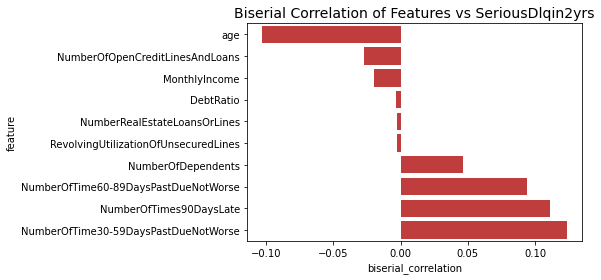

In [232]:
biserial_corr_df = get_biserial_correlation_stats(
    train_df=train_df,
    label_col=LABEL_COL,
    feature_col_list=FEATURES_COL_LIST,
    should_plot=True,
)

From the biserial correlation plot, it seems that:

- `DebtRatio`
- `NumberRealEstateLoansOrLines`
- `RevolvingUtilizationOfUnsecuredLines`

Has very little correlation with the target variable. `RevolvingUtilizationOfUnsecuredLines` has a high feature importance above so this might be contradictive, although this may change as we trim features that are very correlated with each other.

From the correlation plot, we can see that:

- `NumberOfTime30-59DaysPastDueNotWorse`
- `NumberOfTimes90DaysLate`
- `NumberOfTime60-89DaysPastDueNotWorse`

are very correlated with each other. We can keep this in mind and use a subset combinations of them should we need to experiment with dropping the features.


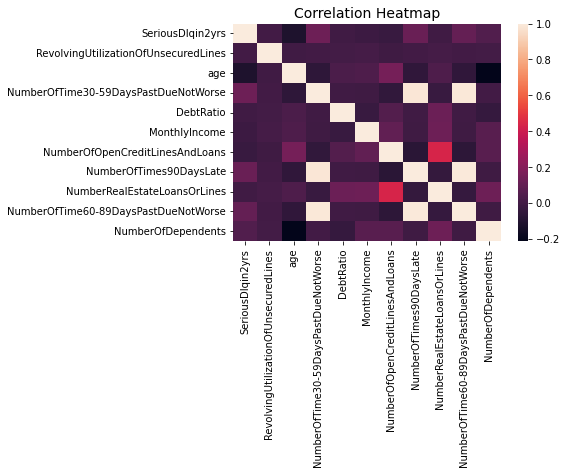

In [233]:
corr_df = get_correlation_df(
    train_df=train_df,
    label_col=LABEL_COL,
    feature_col_list=FEATURES_COL_LIST,
    should_plot=True,
)

### Capping and Imputing Values

From the EDA above, we can see that several columns has outlier values inside (very high values and values that are outside of the possible range).

We will try to cap:
- Ratio-based features at `1.0`
- Non ratio features at `p99`

And see if the model performance improves/deteriorates.

In [234]:
ratio_based_features = ["RevolvingUtilizationOfUnsecuredLines", "DebtRatio"]
non_ratio_based_features = [col for col in FEATURES_COL_LIST if col not in ratio_based_features]

In [235]:
cap_dict = get_cap_dict(
    train_df=train_df,
    ratio_cols=ratio_based_features,
    non_ratio_cols=non_ratio_based_features,
    percentile_for_cap=99.5,
)

capped_train_df = get_capped_df(
    df=train_df,
    cap_dict=cap_dict
)


In [236]:
capped_prelim_clf, capped_prelim_train_roc_auc, capped_prelim_val_roc_auc, capped_ft_importance_df = get_base_rf_auc_feature_importance(
    train_df=capped_train_df,
    label_col=LABEL_COL,
    feature_col_list=FEATURES_COL_LIST,
)

print(f"Preliminary training ROC-AUC score (capped features): {capped_prelim_train_roc_auc:.6f}")
print(f"Preliminary validation ROC-AUC score (capped features): {capped_prelim_val_roc_auc:.6f}")
display(ft_importance_df)
print(cap_dict)

Preliminary training ROC-AUC score (capped features): 0.887607
Preliminary validation ROC-AUC score (capped features): 0.858091


,feature,rf_feature_importance
6,NumberOfTimes90DaysLate,0.255980
0,RevolvingUtilizationOfUnsecuredLines,0.195674
8,NumberOfTime60-89DaysPastDueNotWorse,0.148485
2,NumberOfTime30-59DaysPastDueNotWorse,0.118372
3,DebtRatio,0.074603
4,MonthlyIncome,0.062262
1,age,0.055473
5,NumberOfOpenCreditLinesAndLoans,0.046001
7,NumberRealEstateLoansOrLines,0.022675
9,NumberOfDependents,0.020473


{'RevolvingUtilizationOfUnsecuredLines': 1.0, 'DebtRatio': 1.0, 'age': 89.0, 'NumberOfTime30-59DaysPastDueNotWorse': 5.0, 'MonthlyIncome': 35000.0, 'NumberOfOpenCreditLinesAndLoans': 27.0, 'NumberOfTimes90DaysLate': 4.0, 'NumberRealEstateLoansOrLines': 6.0, 'NumberOfTime60-89DaysPastDueNotWorse': 3.0, 'NumberOfDependents': 5.0}


After capping, we still have a similar training and validation ROC-AUC as before. The capped values will make more sense as well in terms of the actual meaning, especially for the ratio-based features.

Next, we will deal with imputing the missing columns:

- `MonthlyIncome`
- `NumberOfDependents`

We have several alternatives:

- Imputing based on summary statistics (Mean, Median, Mode, etc)
- Predicting the value based on other columns (Regression in both cases)


In [237]:
def get_imputer_and_imputed_df_simple(
    impute_strategy: str,
    original_df: pd.DataFrame,
    label_col: str,
):
    assert impute_strategy in ("mean", "most_frequent", "median"), "impute_strategy must be one of 'mean', 'most_frequent', or 'median'"
    
    imputer = SimpleImputer(strategy=impute_strategy)
    imputer.fit(original_df.dropna(subset=[label_col]))

    imputed_df = pd.DataFrame(columns=original_df.columns, data=imputer.transform(original_df))

    return imputer, imputed_df


def get_imputer_and_imputed_df_regressor(
    regressor_class,
    regressor_kwargs: dict,
    cols_to_impute_via_regression: List[str],
    cols_dtype: List,
    original_df: pd.DataFrame,
    feature_cols_list: List[str],
):

    imputer_dict = {}

    imputed_df = original_df.copy(deep=True)

    for idx, col in enumerate(cols_to_impute_via_regression):
        
        regressor = regressor_class(**regressor_kwargs)

        regressor_impute_train_df = original_df.copy(deep=True)
        regressor_impute_train_df = regressor_impute_train_df.dropna()
        regressor_impute_feature_cols = [col for col in feature_cols_list if col not in cols_to_impute_via_regression]

        X = regressor_impute_train_df[regressor_impute_feature_cols]
        y = regressor_impute_train_df[col]

        regressor.fit(X, y)

        y_pred = regressor.predict(X)

        rmse = np.sqrt(mean_squared_error(y, y_pred))

        # In case need to cast to int, for example for number_of_dependents
        predicted_col = regressor.predict(imputed_df[regressor_impute_feature_cols])
        predicted_col = predicted_col.astype(cols_dtype[idx])

        imputed_df[col] = np.where(
            pd.isnull(imputed_df[col]), predicted_col, imputed_df[col]
        )

        imputer_dict[col] = {
            "regressor" : regressor,
            "feature_cols"  : regressor_impute_feature_cols,
            "rmse" : rmse,
        }
    
    return imputer_dict, imputed_df

In [238]:
mean_imputer, mean_imputed_df = get_imputer_and_imputed_df_simple(
    impute_strategy="mean",
    original_df=train_df,
    label_col=LABEL_COL,
)

median_imputer, median_imputed_df = get_imputer_and_imputed_df_simple(
    impute_strategy="median",
    original_df=train_df,
    label_col=LABEL_COL,
)

mode_imputer, mode_imputed_df = get_imputer_and_imputed_df_simple(
    impute_strategy="most_frequent",
    original_df=train_df,
    label_col=LABEL_COL,
)

regression_imputer_dict, regression_imputed_df = get_imputer_and_imputed_df_regressor(
    RandomForestRegressor,
    regressor_kwargs={"max_depth" : 10},
    cols_to_impute_via_regression=["MonthlyIncome", "NumberOfDependents"],
    cols_dtype=[np.float32, np.int32],
    original_df=train_df,
    feature_cols_list=FEATURES_COL_LIST,
)

In [239]:
impute_eval_dict = {
    "mean" : mean_imputed_df,
    "median" : median_imputed_df,
    "mode" : mode_imputed_df,
    "regression" : regression_imputed_df,
}

for method, method_df in impute_eval_dict.items():

    method_cap_dict = get_cap_dict(method_df, ratio_cols=ratio_based_features, non_ratio_cols=non_ratio_based_features)

    capped_method_df = get_capped_df(method_df, method_cap_dict)

    method_clf, method_train_roc_auc, method_val_roc_auc, method_ft_importance_df = get_base_rf_auc_feature_importance(
        train_df=capped_method_df, 
        label_col=LABEL_COL,
        feature_col_list=FEATURES_COL_LIST,
    )
    print(f"Preliminary training ROC-AUC score ({method} imputation): {method_train_roc_auc:.6f}")
    print(f"Preliminary validation ROC-AUC score ({method} imputation): {method_val_roc_auc:.6f}\n")

Preliminary training ROC-AUC score (mean imputation): 0.892214
Preliminary validation ROC-AUC score (mean imputation): 0.870589

Preliminary training ROC-AUC score (median imputation): 0.890728
Preliminary validation ROC-AUC score (median imputation): 0.869958

Preliminary training ROC-AUC score (mode imputation): 0.891033
Preliminary validation ROC-AUC score (mode imputation): 0.870191

Preliminary training ROC-AUC score (regression imputation): 0.892090
Preliminary validation ROC-AUC score (regression imputation): 0.869983



Here, we see that all imputation methods produce a relatively high score and hence can be considered. However, given that the simple imputation methods are much faster and smaller, it should be preferred in the setting when we are serving the decision in a deployed system, however in a kaggle-like setting, we can consider the regressor-based imputations if that helps us to achieve a higher leaderboard score.

### Modeling

We have prepared the features, and in the next step we will evaluate various classification algorithms:

- `LogisticRegression`
- `DecisionTreeClassifier`
- `RandomForestClassifier`
- `LGBMClassifier`
- `XGBClassifier`
- Ensemble of all the above

that varies in both explainability and predictive power. First we will compare the algorithms without any tuning (only imposing the `max_depth` for tree-based classifiers to prevent degenerate overfitting), and compare the performance in terms of:

- Training time
- Training set query time
- Training set roc_auc
- Validation set roc_auc

To help us make more informed decision about which model to use, before we do hyperparameter tuning.

In order to achieve an apple-to-apple comparison, we will use the same `mean` simple imputation strategy for all variants.

In [240]:
data_idx = np.arange(len(train_df))
train_size = int((1 - VAL_SIZE) * len(train_df))
train_idx_num = np.random.choice(data_idx, size=train_size, replace=False)

train_idx = np.isin(data_idx, train_idx_num)

train_train_df = train_df[train_idx]
train_val_df = train_df[~train_idx]

In [241]:
train_mean_imputer, train_mean_imputed_df = get_imputer_and_imputed_df_simple(
    impute_strategy="mean",
    original_df=train_train_df,
    label_col=LABEL_COL,
)

train_cap_dict = get_cap_dict(
    train_df=train_mean_imputed_df,
    ratio_cols=ratio_based_features,
    non_ratio_cols=non_ratio_based_features,
)

train_imputed_capped_df = get_capped_df(
    df=train_mean_imputed_df,
    cap_dict=train_cap_dict,
)

val_mean_imputed_df = pd.DataFrame(columns=train_val_df.columns, data=train_mean_imputer.transform(train_val_df))

val_imputed_capped_df = get_capped_df(
    df=val_mean_imputed_df,
    cap_dict=train_cap_dict
)

test_mean_imputed_df = pd.DataFrame(columns=test_df.columns, data=train_mean_imputer.transform(test_df))

test_imputed_capped_df = get_capped_df(
    df=test_mean_imputed_df,
    cap_dict=train_cap_dict,
)

In [242]:
X_train = train_imputed_capped_df[FEATURES_COL_LIST]
y_train = train_imputed_capped_df[LABEL_COL].astype(int)

X_val = val_imputed_capped_df[FEATURES_COL_LIST]
y_val = val_imputed_capped_df[LABEL_COL].astype(int)

X_test = test_imputed_capped_df[FEATURES_COL_LIST]
y_test = test_imputed_capped_df[LABEL_COL].astype(int)

In [243]:
def train_and_val_clf(
    clf_class,
    X_train,
    y_train,
    X_val,
    y_val,
    clf_kwargs = dict(),
):
    clf = clf_class(**clf_kwargs)
    train_start_time = time.time()
    clf.fit(X_train, y_train)
    training_time = np.round(time.time() - train_start_time, 2)

    train_query_start_time = time.time()
    y_train_pred = clf.predict_proba(X_train)[:, 1]
    train_query_time = np.round(time.time() - train_query_start_time, 2)

    y_val_pred = clf.predict_proba(X_val)[:, 1]

    train_roc_auc = roc_auc_score(y_train, y_train_pred)
    val_roc_auc = roc_auc_score(y_val, y_val_pred)

    return clf, training_time, train_query_time, train_roc_auc, val_roc_auc

def ensemble_predict_proba(
    model_clf_dict: dict,
    X: pd.DataFrame,
):
    pred = pd.DataFrame(index=X.index)
    pred["Probability"] = np.zeros(len(X))

    for modelname, clf in model_clf_dict.items():
        pred["Probability"] += clf.predict_proba(X)[:, 1]
    
    pred["Probability"] /= len(model_clf_dict)

    return pred

In [244]:
tree_max_depth = int(len(FEATURES_COL_LIST) / 2)

model_eval_dict = {
    "LogisticRegression" : [LogisticRegression, {"class_weight" : "balanced", "max_iter" : 500}],
    "DecisionTreeClassifier" : [DecisionTreeClassifier, {"max_depth" : tree_max_depth}],
    "RandomForestClassifier" : [RandomForestClassifier, {"max_depth" : tree_max_depth, "n_estimators" : 100}],
    "LGBMClassifier" : [LGBMClassifier, {"max_depth" : tree_max_depth, "n_estimators" : 100}],
    "XGBClassifier" : [XGBClassifier, {"max_depth" : tree_max_depth, "n_estimators" : 100, "label_encoder" : False, "eval_metric" : "logloss"}]
}


model_performance_dict = {
    "ModelName" : [],
    "TrainingTime" : [],
    "TrainQueryTime" : [],
    "TrainROC-AUC" : [],
    "ValROC-AUC" : [],
}

model_clf_dict = {}

for model_name, (model_class, model_kwargs) in model_eval_dict.items():
    (
        clf, 
        training_time, 
        train_query_time, 
        train_roc_auc, 
        val_roc_auc, 
    ) = train_and_val_clf(
        clf_class=model_class,
        X_train=X_train,
        y_train=y_train,
        X_val=X_val,
        y_val=y_val,
        clf_kwargs=model_kwargs,
    )

    model_performance_dict["ModelName"].append(model_name)
    model_performance_dict["TrainingTime"].append(training_time)
    model_performance_dict["TrainQueryTime"].append(train_query_time)
    model_performance_dict["TrainROC-AUC"].append(train_roc_auc)
    model_performance_dict["ValROC-AUC"].append(val_roc_auc)
    
    model_clf_dict[model_name] = clf

model_performance_df = pd.DataFrame(model_performance_dict)

/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:21:09] WARNING: /workspace/src/learner.cc:576: 
Parameters: { "label_encoder" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [245]:
model_performance_df

,ModelName,TrainingTime,TrainQueryTime,TrainROC-AUC,ValROC-AUC
0,LogisticRegression,0.58,0.00,0.852714,0.854784
1,DecisionTreeClassifier,0.17,0.01,0.845010,0.846821
2,RandomForestClassifier,3.91,0.41,0.860502,0.861584
3,LGBMClassifier,0.22,0.08,0.881667,0.868580
4,XGBClassifier,1.63,0.03,0.900680,0.865013


In [246]:
ensemble_y_train_pred = ensemble_predict_proba(model_clf_dict, X_train)
ensemble_y_val_pred = ensemble_predict_proba(model_clf_dict, X_val)

ensemble_train_rocauc = roc_auc_score(y_train, ensemble_y_train_pred)
ensemble_val_rocauc = roc_auc_score(y_val, ensemble_y_val_pred)

/usr/local/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/usr/local/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [247]:
ensemble_train_rocauc

0.8730772992607503

In [248]:
ensemble_val_rocauc

0.8643643993900324

In [250]:
test_id = test_df[["id"]]

test_proba = ensemble_predict_proba(
    model_clf_dict=model_clf_dict,
    X=X_test
)

/usr/local/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [252]:
test_id.join(test_proba).to_csv("submission.csv", index=False)